In [1]:
import sys  
sys.path.insert(0, '/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/')
import numpy as np
path_dir = r"/Users/../Volumes/Affiliations/"

In [2]:
import sys  
import pickle
sys.path.insert(0, '/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/')
import numpy as np
import src.utils
from src.utils import import_dta, import_tracks_dta, successful_creators_followers,\
gen_active_relations, get_fan_interactions_per_week, calculate_avg_monthly_valence,\
gen_active_relations_prob, get_fan_interactions_per_week_prob, stripplot_prob,\
reaction_probability, follower_list, filter_quantile, sample_creators_music,\
gen_outbound_creators
import datetime
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mstats
pd.plotting.register_matplotlib_converters()
import os

import src.probability_utils
from src.probability_utils import volume_analysis, valence_analysis
import math
import matplotlib.ticker as plticker
from scipy.interpolate import make_interp_spline, BSpline
import seaborn as sns
from numpy import random
from tabulate import tabulate
from IPython.display import display
from tqdm import tqdm

In [3]:
def process_date(date):
    year = date[0:4]
    week = date[6:]
    day = "1"
    date = "{}-{}-1".format(year, week)
    dt = datetime.strptime(date, "%Y-%W-%w")
    return dt

In [4]:
path_dir = r"/Users/../Volumes/Raw/"
music_before = 14
low_success = 0.50
high_success = 0.9
rank_percentiles = False

In [5]:
#we will skip comments for now

#affiliations :follows
#favoritings :likes

tracks = import_tracks_dta(path_dir, "12sample_tracks.dta");
follows_sent = import_dta(path_dir, "12sample_affiliations_sent.dta");
comments_sent = import_dta(path_dir, "12sample_comments_made.dta");
shares_sent = import_dta(path_dir, "12sample_reposts_made.dta");
likes_sent = import_dta(path_dir, "12sample_favoritings_made.dta");
messages_sent = import_dta(path_dir, "12sample_messages_sent.dta");

user_info = import_dta(path_dir, "12sample_user_infos.dta");
user_info.columns = ['user_id', 'type', 'entered_platform']
user_info_2 = import_dta(path_dir, "12sample_1st_deg_user_infos.dta");
user_info_2.columns = ['user_id', 'type', 'entered_platform']
user_info = pd.concat([user_info, user_info_2]);
user_info.drop_duplicates(subset='user_id', keep='first', inplace=True, ignore_index=False);


########
follows_received = import_dta(path_dir, "12sample_affiliations_received.dta");
comments_received = import_dta(path_dir, "12sample_comments_received.dta");
shares_received = import_dta(path_dir, "12sample_reposts_received.dta");
likes_received = import_dta(path_dir, "12sample_favoritings_received.dta");
messages_received = import_dta(path_dir, "12sample_messages_received.dta");

########
follows = import_dta(path_dir, "12sample_affiliations.dta");
comments = import_dta(path_dir, "12sample_comments.dta");
shares = import_dta(path_dir, "12sample_reposts.dta");
likes = import_dta(path_dir, "12sample_favoritings.dta");
messages = import_dta(path_dir, "12sample_messages.dta");

tracks_first_month = sample_creators_music(tracks, music_before)
mask = tracks_first_month.track_available == 1
tracks_first_month = tracks_first_month[mask]

mask = follows_received.contact_id.isin(tracks_first_month.user_id)
follows_received_30 = follows_received[mask]
followers_per_creator_60 = successful_creators_followers(follows_received_30, 60, tracks_first_month)
followers_per_creator_60_static = successful_creators_followers(follows_received_30, 60, tracks_first_month, always_same_batches = True, 
                                                        perc1 = low_success, perc2 = high_success)

%%%%%%%%%% 12sample_tracks.dta %%%%%%%%%%
(56262, 7)
%%%%%%%%%% 12sample_affiliations_sent.dta %%%%%%%%%%
(800913, 3)
%%%%%%%%%% 12sample_comments_made.dta %%%%%%%%%%
(29258, 4)
%%%%%%%%%% 12sample_reposts_made.dta %%%%%%%%%%
(179329, 4)
%%%%%%%%%% 12sample_favoritings_made.dta %%%%%%%%%%
(527701, 4)
%%%%%%%%%% 12sample_messages_sent.dta %%%%%%%%%%
(11091, 3)
%%%%%%%%%% 12sample_user_infos.dta %%%%%%%%%%
(35000, 3)
%%%%%%%%%% 12sample_1st_deg_user_infos.dta %%%%%%%%%%
(670746, 3)
%%%%%%%%%% 12sample_affiliations_received.dta %%%%%%%%%%
(432503, 3)
%%%%%%%%%% 12sample_comments_received.dta %%%%%%%%%%
(21386, 4)
%%%%%%%%%% 12sample_reposts_received.dta %%%%%%%%%%
(83013, 4)
%%%%%%%%%% 12sample_favoritings_received.dta %%%%%%%%%%
(286903, 4)
%%%%%%%%%% 12sample_messages_received.dta %%%%%%%%%%
(17364, 3)
%%%%%%%%%% 12sample_affiliations.dta %%%%%%%%%%
(1233416, 3)
%%%%%%%%%% 12sample_comments.dta %%%%%%%%%%
(50644, 4)
%%%%%%%%%% 12sample_reposts.dta %%%%%%%%%%
(262342, 4)
%%%%%%%%%% 12sam

In [6]:
path_dir = r"/Users/../Volumes/Track_plays/"

In [7]:
track_plays = import_dta(path_dir, "12sample_plays_made.dta");

%%%%%%%%%% 12sample_plays_made.dta %%%%%%%%%%
(22229007, 6)


In [8]:
#database 1
actions_sent = gen_outbound_creators(follows_sent, shares_sent, likes_sent, comments_sent, tracks,
                                     messages_sent = messages_sent, filter_creators = True)
mask = actions_sent.user_id.isin(tracks_first_month.user_id.unique())
actions_sent = actions_sent[mask]

In [9]:
shares_received.head()

,reposter_id,created_at,song_id,owner_id
0,33635491,2013-03-05 05:50:34,81704043,38135744
1,38321910,2013-03-05 23:11:40,81662402,38123852
2,38263941,2013-03-06 17:43:46,81891814,38263941
3,38470533,2013-03-09 13:10:51,82222212,38470533
4,6746343,2013-03-11 06:32:23,82702273,38145276


In [10]:
def gen_inbound_creators(follows_received, shares_received, likes_received, comments_received, messages_received):
    follows_received['outbound_activity'] = 'follow'
    follows_received.columns = ['fan_id', 'user_id', 'date_sent', 'inbound_activity']

    if 'song_id' in shares_received.columns:
        shares_received.drop(columns=["song_id"])
    shares_received = shares_received[['reposter_id', "owner_id", 'created_at']]
    shares_received['inbound_activity'] = 'share'
    shares_received.columns = ['fan_id', 'user_id', 'date_sent', 'inbound_activity']

    if 'track_id' in likes_received.columns:
        likes_received.drop(columns=["track_id"], inplace=True)
    likes_received['inbound_activity'] = 'like'
    likes_received.columns = ['fan_id', 'user_id', 'date_sent', 'inbound_activity']

    if 'track_id' in comments_received.columns:
        comments_received.drop(columns=["track_id"], inplace=True)
    comments_received['inbound_activity'] = 'comment'
    comments_received.columns = ['fan_id', 'user_id', 'date_sent', 'inbound_activity']

    messages_received["inbound_activity"] = 'message'
    messages_received.columns = ['fan_id', 'user_id', 'date_sent', 'inbound_activity']
    df = pd.concat([follows_received, shares_received, likes_received, comments_received, messages_received])


    df['interaction_week'] = df.date_sent.apply(lambda x: x.week)
    df['interaction_year'] = df.date_sent.apply(lambda x: x.year)
    df['week_yr'] = df.date_sent.dt.strftime('%Y-w%U')
    df = df.loc[df['user_id'] != df['fan_id'],:]

    return df

In [11]:
#database 2
inbound_activities = gen_inbound_creators(follows_received, shares_received, likes_received, comments_received, messages_received)

In [12]:
#database 3
track_plays
mask = track_plays.listener_id.isin(tracks_first_month.user_id.unique())
creator_log_ins = track_plays[mask]

In [13]:
activities_log_ins = actions_sent[['user_id', 'date_sent', 'outbound_activity']]
activities_log_ins.columns = ['user_id', 'log_in', 'activity']

In [14]:
creator_log_ins['activity'] = 'track_play'
creator_log_ins = creator_log_ins[['listener_id', 'created_at','activity']]
creator_log_ins.columns = ['user_id', 'log_in','activity']

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_83744/586695460.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  creator_log_ins['activity'] = 'track_play'


In [15]:
log_ins = pd.concat([activities_log_ins,creator_log_ins])

In [16]:
# merges

In [17]:
actions_sent.sort_values('date_sent', inplace = True)
inbound_activities.sort_values('date_sent', inplace = True)
inbound_activities['reaction_date'] = inbound_activities['date_sent']

In [18]:
actions_and_reactions = pd.merge_asof(actions_sent, inbound_activities[['user_id', 'fan_id', 'inbound_activity', 'date_sent', 'reaction_date']]
                     , left_by= ['user_id', 'fan_id'], right_by= ['user_id', 'fan_id'],
             on = 'date_sent', direction = 'forward', tolerance=pd.Timedelta('10days'))

In [19]:
sum(actions_and_reactions.inbound_activity.isnull())

126108

In [20]:
mask = actions_and_reactions.inbound_activity.isnull() == False
actions_and_reactions = actions_and_reactions[mask]

In [21]:
user_id = 38393304
fan_id = 123155586

In [22]:
inbound_activities.loc[(inbound_activities['user_id'] == user_id) & (inbound_activities['fan_id'] == fan_id)]

,fan_id,user_id,date_sent,inbound_activity,interaction_week,interaction_year,week_yr,reaction_date
320040,123155586,38393304,2014-11-16 00:30:07,follow,46,2014,2014-w46,2014-11-16 00:30:07
247473,123155586,38393304,2015-05-19 17:23:52,like,21,2015,2015-w20,2015-05-19 17:23:52
256530,123155586,38393304,2015-07-12 18:28:58,like,28,2015,2015-w28,2015-07-12 18:28:58
6125,123155586,38393304,2015-07-15 00:34:09,comment,29,2015,2015-w28,2015-07-15 00:34:09


In [23]:
actions_sent.loc[(actions_sent['user_id'] == user_id) & (actions_sent['fan_id'] == fan_id)]

,user_id,fan_id,date_sent,outbound_activity,interaction_week,interaction_year,week_yr
179230,38393304,123155586,2015-03-31 02:13:16,share,14,2015,2015-w13
500111,38393304,123155586,2015-03-31 02:13:20,like,14,2015,2015-w13
173285,38393304,123155586,2015-04-06 15:32:40,share,15,2015,2015-w14
518726,38393304,123155586,2015-04-06 15:32:45,like,15,2015,2015-w14
162894,38393304,123155586,2015-04-13 12:53:26,share,16,2015,2015-w15
772070,38393304,123155586,2015-04-20 16:56:12,follow,17,2015,2015-w16
175380,38393304,123155586,2015-04-21 23:12:53,share,17,2015,2015-w16
502669,38393304,123155586,2015-04-27 16:53:51,like,18,2015,2015-w17
165957,38393304,123155586,2015-04-29 02:30:24,share,18,2015,2015-w17
175055,38393304,123155586,2015-05-05 00:54:31,share,19,2015,2015-w18


In [24]:
actions_and_reactions.loc[(actions_and_reactions['user_id'] == user_id) & (actions_and_reactions['fan_id'] == fan_id)]

,user_id,fan_id,date_sent,outbound_activity,interaction_week,interaction_year,week_yr,inbound_activity,reaction_date
135846,38393304,123155586,2015-05-12 15:25:45,share,20,2015,2015-w19,like,2015-05-19 17:23:52
135847,38393304,123155586,2015-05-12 15:25:51,like,20,2015,2015-w19,like,2015-05-19 17:23:52
136307,38393304,123155586,2015-05-18 12:19:32,share,21,2015,2015-w20,like,2015-05-19 17:23:52
139861,38393304,123155586,2015-07-10 23:25:36,like,28,2015,2015-w27,like,2015-07-12 18:28:58


In [25]:
#log-ins 

In [26]:
mask = log_ins.log_in < (min(actions_and_reactions.date_sent) + pd.Timedelta('14days'))

log_ins = log_ins[mask]
log_ins

,user_id,log_in,activity
923,37936033,2013-03-02 02:56:11,follow
1138,37865131,2013-03-02 08:39:29,follow
1242,37979645,2013-03-02 14:21:10,follow
1370,38028761,2013-03-03 00:00:55,follow
1371,38028761,2013-03-03 00:00:55,follow
...,...,...,...
968508,38150682,2013-03-14 21:42:29,track_play
968513,38057916,2013-03-14 21:56:36,track_play
968520,37961134,2013-03-14 22:03:32,track_play
968521,38324468,2013-03-14 22:13:36,track_play


In [27]:
#restrict to 2 weeks

In [28]:
mask = actions_and_reactions.date_sent < (min(actions_and_reactions.date_sent) + pd.Timedelta('14days'))

actions_and_reactions = actions_and_reactions[mask]

In [29]:
actions_and_reactions.sort_values('reaction_date', inplace = True)
log_ins.sort_values('log_in', inplace = True)

In [30]:
analysis_df = pd.merge_asof(actions_and_reactions, log_ins
                     , left_by= ['user_id'], right_by= ['user_id'],
             left_on = 'reaction_date', right_on = 'log_in', direction = 'forward',
             tolerance=pd.Timedelta('10days'))

In [31]:
sum(analysis_df.log_in.isnull())

570

In [32]:
analysis_df['time_to_reaction'] = analysis_df['reaction_date'] - analysis_df['date_sent']
analysis_df['time_to_log_in'] = analysis_df['log_in'] - analysis_df['reaction_date']

In [33]:
mask = analysis_df.date_sent < (max(analysis_df.date_sent) - pd.Timedelta('10days'))
analysis_df = analysis_df[mask]

In [34]:
analysis_df.time_to_reaction.describe()

count                         1258
mean     1 days 15:34:14.064387917
std      2 days 09:32:17.921465229
min                0 days 00:00:01
25%         0 days 01:03:01.750000
50%                0 days 11:42:02
75%         2 days 03:04:16.750000
max                9 days 23:59:10
Name: time_to_reaction, dtype: object

In [35]:
analysis_df.time_to_log_in.describe()

count                         1115
mean     0 days 16:01:25.091479820
std      1 days 06:29:27.603344384
min                0 days 00:00:00
25%         0 days 00:09:32.500000
50%                0 days 02:17:39
75%                0 days 15:19:15
max                8 days 13:51:21
Name: time_to_log_in, dtype: object

In [259]:
analysis_df = analysis_df.merge(followers_per_creator_60_static, left_on = 'user_id', right_on = 'user_id', how = 'inner')

In [357]:
analysis_df['Creator_type'] = analysis_df['high_low'].apply(lambda x : 'Successful' if x == 'high' else 'Unsuccessful')

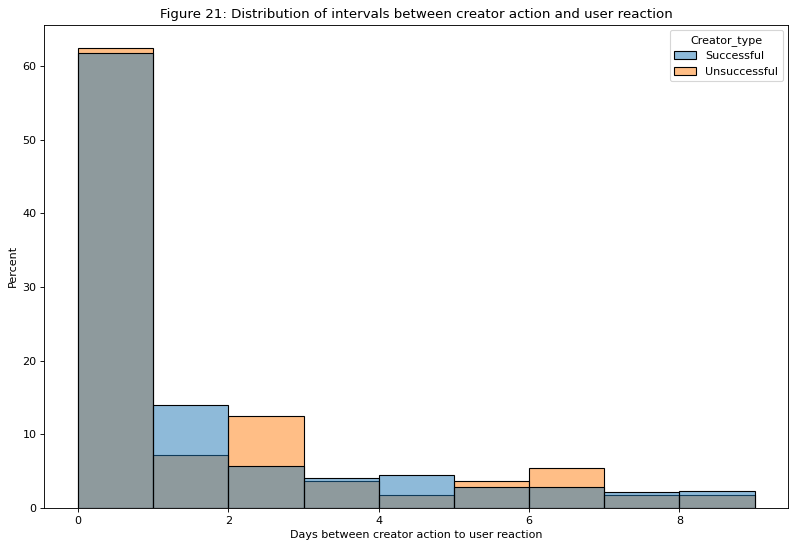

In [358]:
analysis_df['time_to_reaction_d'] = analysis_df.time_to_reaction.astype('timedelta64[D]')

plot_f(analysis_df, 'time_to_reaction_d', 9,
       "Figure 21: Distribution of intervals between creator action and user reaction", 
       'Days between creator action to user reaction', hue = 'Creator_type', common_norm = False)

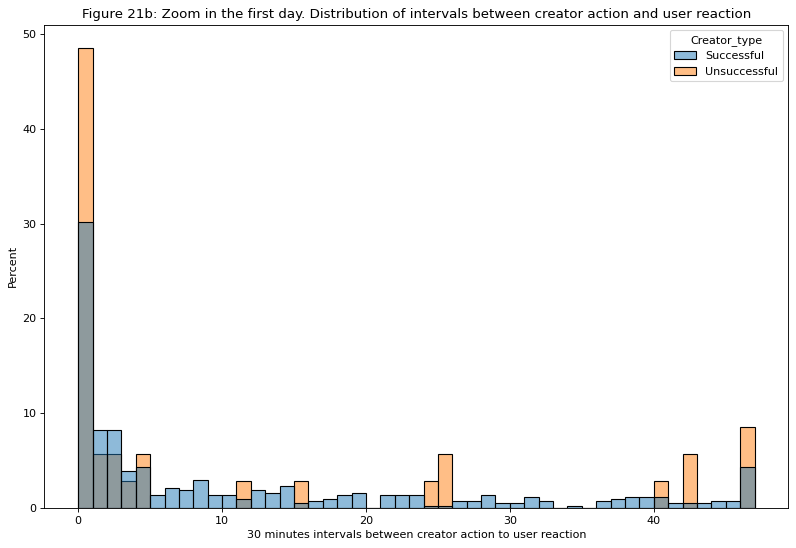

In [359]:
mask = analysis_df.time_to_reaction.astype('timedelta64[D]') < 1
analysis_df['time_to_reaction_30m'] = analysis_df.time_to_reaction.astype('timedelta64[30m]')

plot_f(analysis_df[mask], 'time_to_reaction_30m', 47,
       "Figure 21b: Zoom in the first day. Distribution of intervals between creator action and user reaction", 
       '30 minutes intervals between creator action to user reaction', hue = 'Creator_type', common_norm = False)

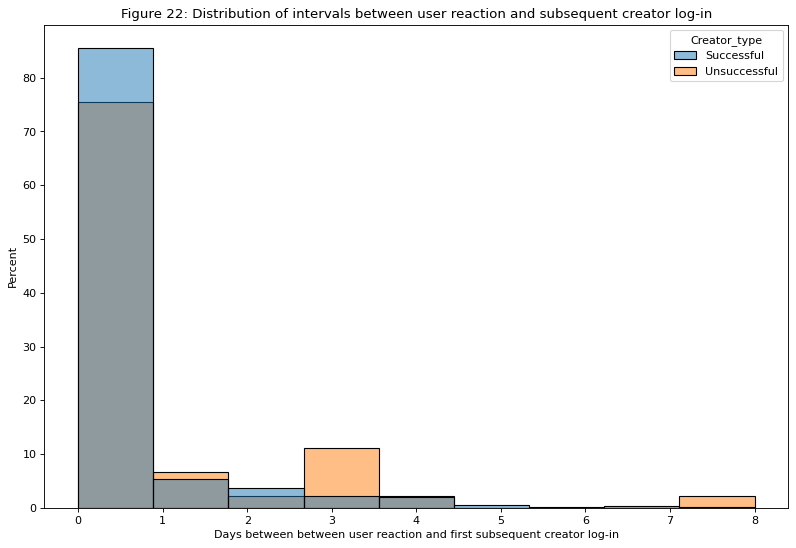

In [360]:
analysis_df['time_to_log_in_d'] = analysis_df.time_to_log_in.astype('timedelta64[D]')

plot_f(analysis_df, 'time_to_log_in_d', 9,
       "Figure 22: Distribution of intervals between user reaction and subsequent creator log-in", 
       'Days between between user reaction and first subsequent creator log-in',
       hue = 'Creator_type', common_norm = False)

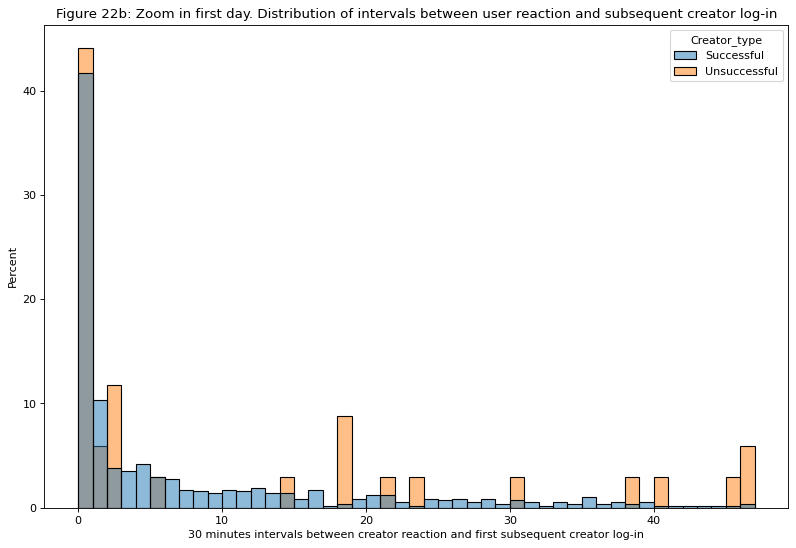

In [361]:
mask = analysis_df.time_to_log_in.astype('timedelta64[D]') < 1
analysis_df['time_to_log_in_30m'] = analysis_df.time_to_log_in.astype('timedelta64[30m]')

plot_f(analysis_df[mask], 'time_to_log_in_30m', 47,
       "Figure 22b: Zoom in first day. Distribution of intervals between user reaction and subsequent creator log-in", 
       '30 minutes intervals between creator reaction and first subsequent creator log-in',
       hue = 'Creator_type', common_norm = False)

In [40]:
actions_and_reactions

,user_id,fan_id,date_sent,outbound_activity,interaction_week,interaction_year,week_yr,inbound_activity,reaction_date
94,37824681,20492763,2013-03-01 00:38:33,follow,9,2013,2013-w08,follow,2013-03-01 00:39:06
252,37827529,11488907,2013-03-01 00:52:24,message,9,2013,2013-w08,comment,2013-03-01 01:02:09
262,37827529,11488907,2013-03-01 01:04:22,follow,9,2013,2013-w08,comment,2013-03-01 01:04:56
269,37824681,28451863,2013-03-01 01:47:17,follow,9,2013,2013-w08,follow,2013-03-01 01:47:20
367,37824681,5582390,2013-03-01 02:00:55,like,9,2013,2013-w08,follow,2013-03-01 02:01:42
...,...,...,...,...,...,...,...,...,...
49714,38290748,26594592,2013-03-14 12:41:58,follow,11,2013,2013-w10,follow,2013-03-22 00:13:13
48090,37846167,31126894,2013-03-12 09:27:40,follow,11,2013,2013-w10,follow,2013-03-22 04:35:21
48974,38489844,30896102,2013-03-13 20:32:16,follow,11,2013,2013-w10,like,2013-03-22 10:22:24
49872,38183207,721701,2013-03-14 21:20:07,follow,11,2013,2013-w10,follow,2013-03-23 17:45:56


# Session analysis

In [42]:
log_ins

,user_id,log_in,activity
111745,37824072,2013-03-01 00:00:38,follow
111744,37824072,2013-03-01 00:00:38,follow
111746,37824072,2013-03-01 00:00:38,follow
111747,37824072,2013-03-01 00:00:38,follow
111763,37824072,2013-03-01 00:00:38,follow
...,...,...,...
959667,38037998,2013-03-15 00:20:55,track_play
603396,38026587,2013-03-15 00:21:47,track_play
938155,37888260,2013-03-15 00:21:57,track_play
596561,37888260,2013-03-15 00:22:04,track_play


In [43]:
def attribute_sessions(df):
    df.sort_values(by = ['user_id', 'log_in'], inplace = True)
    df['session'] = np.nan
    interval = pd.Timedelta('30minutes')
    j = 0
    for user in df.user_id.unique():
        session = 1
        for i in range(df.loc[df.user_id == user,:].shape[0]):
            df.iloc[j, -1] = session
            try:
                if (df.iloc[j+1, 1] - df.iloc[j, 1]) > interval:
                    session += 1
            except IndexError as e:
                if j+1 == df.shape[0]:
                    print('Reached End of File.')
            j += 1
    return df

In [176]:
log_ins_t = attribute_sessions(log_ins)

Reached End of File.


In [177]:
creator_sessions = log_ins_t.groupby(['user_id', 'session'], as_index = False).agg(session_end=('log_in', max), session_start=('log_in', 'min'))
creator_sessions = creator_sessions.merge(user_info[['user_id','entered_platform']], left_on = 'user_id', right_on = 'user_id')

In [178]:
delta_M = dt.timedelta(days=14)
date = dt.datetime(2013, 3, 1, 0, 0, 0) + delta_M
creator_sessions['interval_bt_sessions'] = np.nan 
previous_user = 99999999
for i in tqdm(range(creator_sessions.shape[0])):
    user = creator_sessions.iloc[i, 0] 
    try:
        next_user = creator_sessions.iloc[i+1, 0]
        if user != next_user:
            creator_sessions.loc[i, 'interval_bt_sessions'] = max(date - (creator_sessions.loc[i, 'session_end']), pd.Timedelta('0'))
        elif user == previous_user:
            creator_sessions.loc[i, 'interval_bt_sessions'] = creator_sessions.loc[i,'session_start'] - creator_sessions.loc[i-1,'session_end'] 
        else:
            creator_sessions.loc[i, 'interval_bt_sessions'] = creator_sessions.loc[i,'session_start'] - creator_sessions.loc[i,'entered_platform'] 
        previous_user = user
    except:
        creator_sessions.loc[i, 'interval_bt_sessions'] = date - (creator_sessions.loc[i, 'session_end'])
        print('end of file.')                                 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13366/13366 [00:01<00:00, 9540.68it/s]

end of file.


In [180]:
creator_sessions['interval_bt_sessions'] = creator_sessions.interval_bt_sessions.map(lambda x: pd.to_timedelta(x))
creator_sessions['interval_bt_sessions_hours'] = creator_sessions.interval_bt_sessions.map(lambda x: x.seconds//(60*60))
creator_sessions['interval_bt_sessions_days'] = creator_sessions.interval_bt_sessions.map(lambda x: x.days)

In [127]:
mask = (creator_sessions.interval_bt_sessions.isnull() == False)

In [323]:
creator_sessions_ = creator_sessions.merge(followers_per_creator_60_static, left_on = 'user_id', right_on = 'user_id', how = 'inner')

In [325]:
creator_sessions_['Creator_type'] = creator_sessions_['high_low'].apply(lambda x : 'Successful' if x == 'high' else 'Unsuccessful')

In [333]:
def plot_f(data, x , bins, title,x_label, hue = None, common_norm = True):
    
    order = [1,2,0]
    figure(figsize=(12, 8), dpi=80)

    g = sns.histplot(data = data, x = x, stat = 'percent', bins = bins, hue = hue, common_norm = common_norm).\
    set(title = title, 
        xlabel = x_label); 

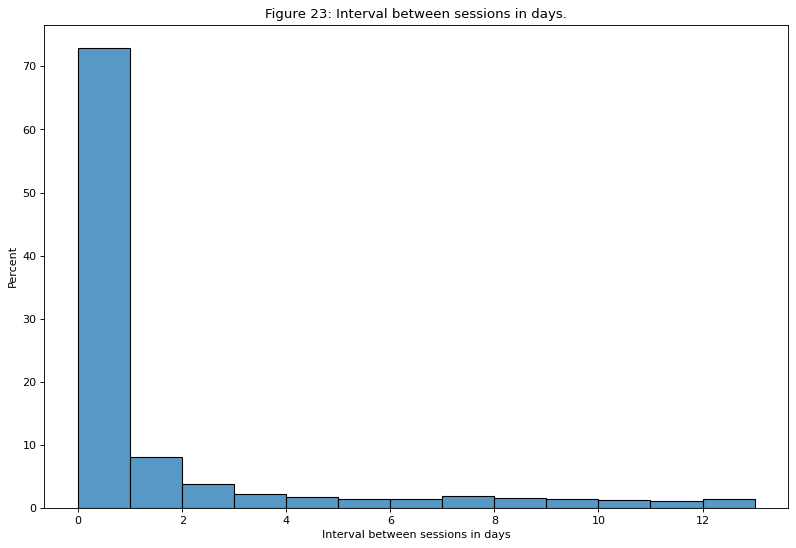

In [334]:
creator_sessions['interval_bt_sessions_days_truncated'] = creator_sessions.interval_bt_sessions.astype('timedelta64[D]').\
apply(lambda x: 30 if x > 30 else x)

plot_f(creator_sessions, 'interval_bt_sessions_days_truncated',13,
       "Figure 23: Interval between sessions in days.", 
       'Interval between sessions in days', hue = None, common_norm = True)

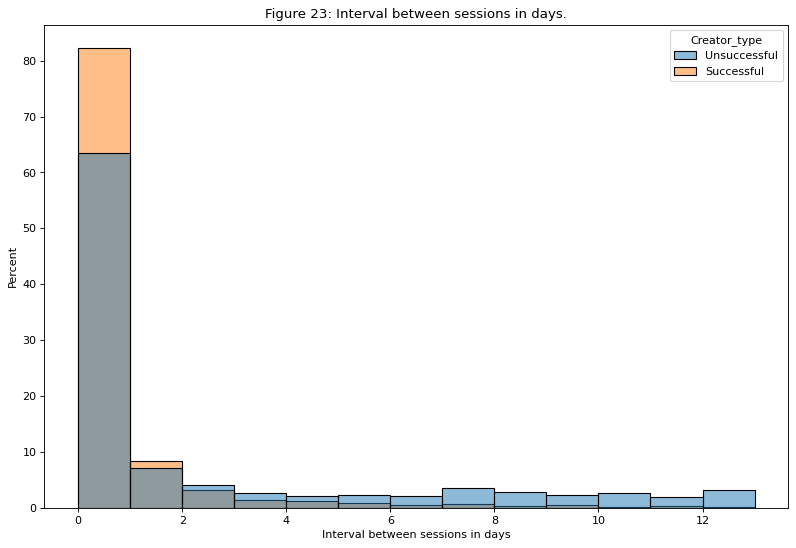

In [335]:
creator_sessions_['interval_bt_sessions_days_truncated'] = creator_sessions_.interval_bt_sessions.astype('timedelta64[D]').\
apply(lambda x: 30 if x > 30 else x)

plot_f(creator_sessions_, 'interval_bt_sessions_days_truncated',13,
       "Figure 23: Interval between sessions in days.", 
       'Interval between sessions in days', hue = 'Creator_type', common_norm = False)

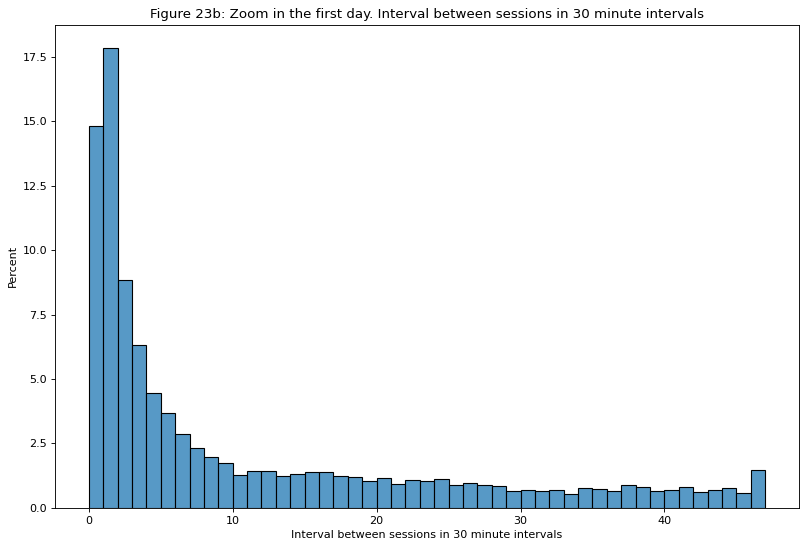

In [336]:
import datetime as dt
figure(figsize=(12, 8), dpi=80)
mask = creator_sessions.interval_bt_sessions.astype('timedelta64[D]') < 1

sns.histplot(creator_sessions[mask].interval_bt_sessions.astype('timedelta64[30m]'), stat = 'percent', bins = 47).\
set(title = "Figure 23b: Zoom in the first day. Interval between sessions in 30 minute intervals", 
    xlabel = 'Interval between sessions in 30 minute intervals');

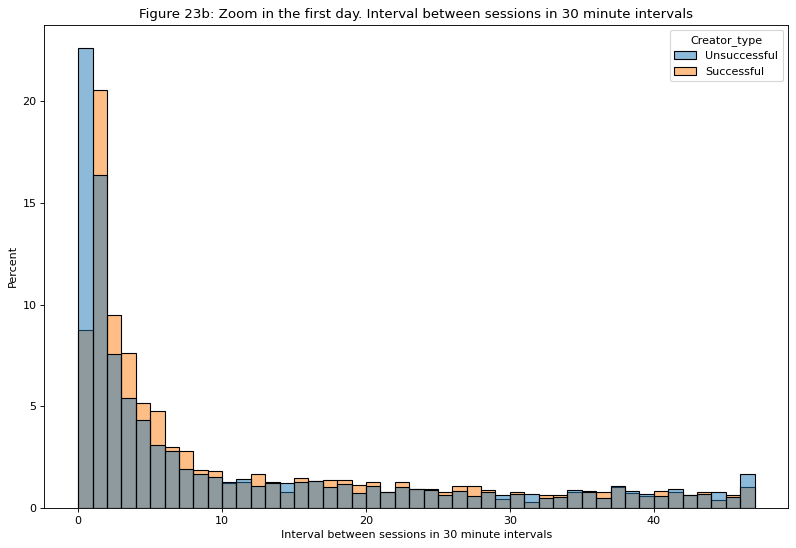

In [362]:
mask = creator_sessions_.interval_bt_sessions.astype('timedelta64[D]') < 1
creator_sessions_['interval_bt_sessions_30'] = creator_sessions_.interval_bt_sessions.astype('timedelta64[30m]')

plot_f(creator_sessions_[mask], 'interval_bt_sessions_30',47,
       "Figure 23b: Zoom in the first day. Interval between sessions in 30 minute intervals", 
       'Interval between sessions in 30 minute intervals', hue = 'Creator_type', common_norm = False)

In [338]:
users_len = creator_sessions_.groupby('user_id').size()
users_len_1 = users_len[ users_len == 1].index

In [339]:
delta_M = dt.timedelta(days=14)
date = dt.datetime(2013, 3, 1, 0, 0, 0) + delta_M
creator_sessions['total_possible_time'] = date - creator_sessions.entered_platform

In [340]:
creator_sessions['interval_bt_sessions_na_0'] = creator_sessions['interval_bt_sessions']
mask = creator_sessions.user_id.isin(users_len_1)
creator_sessions.loc[mask, 'interval_bt_sessions_na_0'] = creator_sessions.loc[mask, 'total_possible_time']
intervals = creator_sessions.groupby('user_id', as_index = False).agg(time_not_logged_in = ('interval_bt_sessions_na_0', np.nansum), 
                                                                     total_possible_time = ('total_possible_time', np.mean))

In [341]:
pct_logged_in = intervals
pct_logged_in['Ratio'] = (intervals.total_possible_time - intervals.time_not_logged_in)/intervals.total_possible_time


In [342]:
pct_logged_in_ = pct_logged_in
pct_logged_in_ = pct_logged_in_.merge(followers_per_creator_60_static, left_on = 'user_id', right_on = 'user_id', how = 'inner')

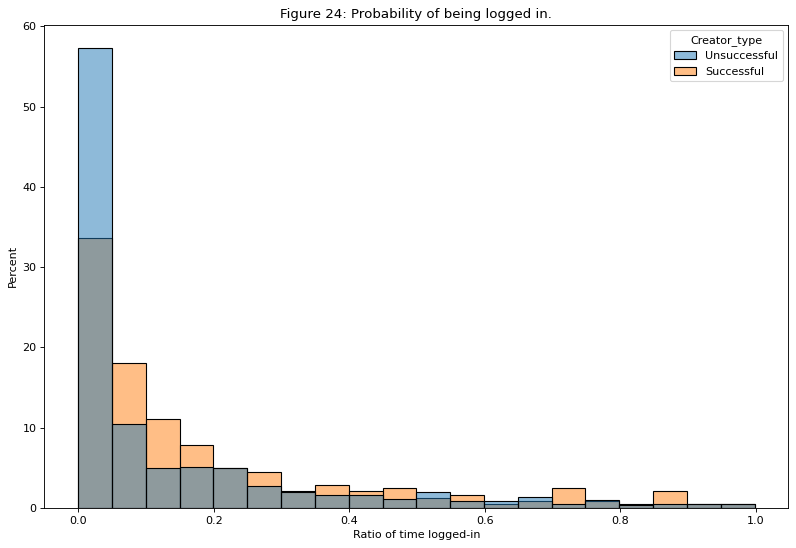

In [364]:
import datetime as dt
figure(figsize=(12, 8), dpi=80)
pct_logged_in_['Creator_type'] = pct_logged_in_['high_low'].apply(lambda x : 'Successful' if x == 'high' else 'Unsuccessful')

sns.histplot(data = pct_logged_in_, x = 'Ratio', stat = 'percent', bins = 20,
            hue = 'Creator_type', common_norm = False).\
set(title = "Figure 24: Probability of being logged in.", 
    xlabel = 'Ratio of time logged-in');

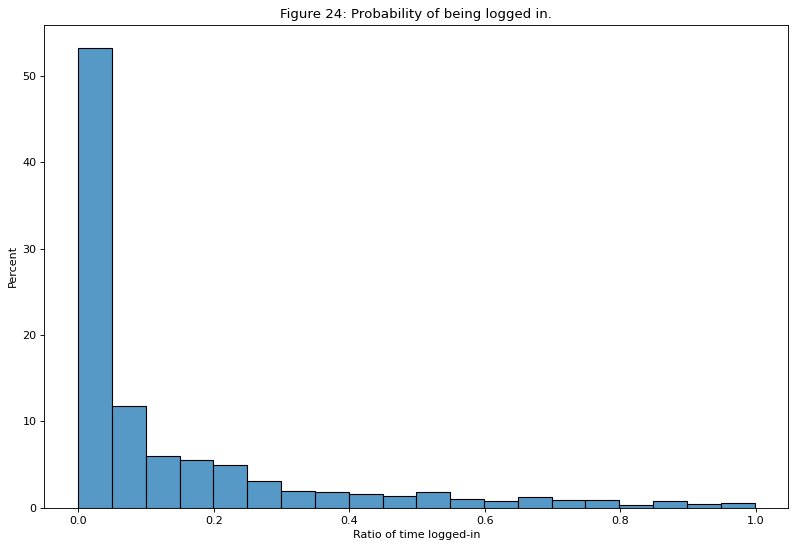

In [349]:
import datetime as dt
figure(figsize=(12, 8), dpi=80)
mask = creator_sessions.interval_bt_sessions.astype('timedelta64[D]') < 1

sns.histplot(data = pct_logged_in_, x = 'Ratio', stat = 'percent', bins = 20).\
set(title = "Figure 24: Probability of being logged in.", 
    xlabel = 'Ratio of time logged-in');

In [344]:
creator_sessions.loc[creator_sessions.user_id == 37824662]

,user_id,session,session_end,session_start,entered_platform,interval_bt_sessions,interval_bt_sessions_hours,interval_bt_sessions_days,interval_bt_sessions_days_truncated,interval_bt_sessions_30,total_possible_time,interval_bt_sessions_na_0
20,37824662,1.0,2013-03-01 00:11:57,2013-03-01 00:11:57,2013-03-01 00:06:47,0 days 00:05:10,0,0,0.0,0.0,13 days 23:53:13,0 days 00:05:10
21,37824662,2.0,2013-03-01 02:41:42,2013-03-01 02:38:21,2013-03-01 00:06:47,13 days 21:18:18,21,13,13.0,666.0,13 days 23:53:13,13 days 21:18:18


In [ ]:
#correct calculation so time to first and time to first and time to last are also considered time not logged it, 
#maybe check date they entered the platform 